# Solnet: Open-source deep learning models for global PV power forecasting

## Imports

In [1]:
import torch

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse

from src.Data_fetching import get_pvgis_hourly
from src.Data_fetching import get_open_meteo_hourly
from src.Tensors import Tensors
from src.Lstm import LSTM
from src.Lstm import Training

from collections import defaultdict

# Sklearn does not have an MBE metric so we create one here
def mbe(x, y):
    mbe = np.mean(np.subtract(x, y))
    return mbe

def pinball_loss(y_true, y_pred, q):
    diff = y_true - y_pred
    return np.maximum(q * diff, (q - 1) * diff)

## Parameters

First we have to specify all the parameters required to gather our data and run our models.

In [2]:
# In here we specify all the parameters needed for a run:

# Data fetching
latitude =-33.7177
longitude = 151.1152
optimal_angles = 1                                                                    # 1 if azimuth and tilt are not known, otherwise 0
azimuth = None                                                                        # None if azimuth is not known
tilt = None                                                                           # None if tilt is not known
peak_power = 2.48                                                                     # The peak output of the system
loss = 14                                                                             # The percentage system loss; PVGIS takes 14% as baseline

# Forecasting parameters
target = 'P'                                                                          # PV Power
past_features = ['P']                                                                 # Lagged PV power
future_features = ['hour_sin',                                                        #
                   'hour_cos',
                   'relative_humidity_2m',
                   'diffuse_radiation',
                   'direct_radiation']
feat_count = len(past_features) + len(future_features)

lags = 24                                                                             # How many lags we want to use in our model
forecast_period = 24                                                                  # How many hours we want to forecast
gap = 0                                                                               # Wether or not there is a gap between the time the forecast is made and the first hour to forecast
forecast_gap = 0                                                                      # Wether or not there is a gap between the forecasts (for example only every other day: 24)

# Lstm parameters
hidden_size = 200                                                                     # Size of the hidden state
num_layers = 3                                                                        # Number of layers in our LSTM
dropout = 0.5                                                                         # Dropout percentage for training, avoids overfitting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                 # Cuda device, if enabled

# Training parameters
epochs = 200                                                                           # Number of loops through the entire dataset
batch_size = 32                                                                       # Number of samples processed per forward and backward pass
learning_rate = 0.001                                                                 # The parameter specifying the step size of the update after each backwards pass

# Model
model_name = 'Sydney_1'                                                               # The name attached to the model

## Gather data

### PV data

First we need synthetic PV data to create our source model which is the starting point for transfer learning. For this, we use PVGIS, an open source tool which provides PV data for any land based location on earth.

In [3]:
start_date = 2005
end_date = None

parameters_PVGIS = {'lat': latitude,
              'lon': longitude,
              'startyear': start_date,
              'endyear': end_date,
              'outputformat': 'json',
              'angle': tilt,
              'aspect': azimuth,
              'optimalangles': optimal_angles,
              'pvcalculation': 1,
              'components': 1,
              'peakpower': peak_power,
              'loss': loss,
              'localtime': 0}

In [4]:
pv_data = get_pvgis_hourly(parameters_PVGIS)[['P']]
pv_data.head(5)

,P
time,
2005-01-01 00:30:00+00:00,1701.08
2005-01-01 01:30:00+00:00,1687.37
2005-01-01 02:30:00+00:00,1667.68
2005-01-01 03:30:00+00:00,1640.99
2005-01-01 04:30:00+00:00,1356.56


In [5]:
pv_data.index = pv_data.index.tz_convert("Australia/Sydney").tz_localize(None)
pv_data.index = pv_data.index.floor('h')
pv_data = pv_data[13:-11]

### Cyclical features

We can add information on the hour of the day (or any other time related feature) to help improve the forecasting performance of our model. There are several ways to do this but the best way is to use cyclical encoding using a sine and cosine function.

In [6]:
pv_data.loc[:, 'hour_sin'] = np.sin(2 * np.pi * pv_data.index.hour / 24)
pv_data.loc[:, 'hour_cos'] = np.cos(2 * np.pi * pv_data.index.hour / 24)

### Weather data

Next we need weather data to improve the forecasting performance of our model.

In [7]:
parameters_open_meteo = {"latitude": latitude,
                         "longitude": longitude,
                         "start_date": pv_data.index[0].date() - pd.Timedelta(days=1),
                         "end_date": pv_data.index[-1].date(),
                         "hourly": ["relative_humidity_2m",
                                    "direct_radiation",
                                    "diffuse_radiation"],
                         "models": "best_match"}

In [8]:
weather_data = get_open_meteo_hourly(parameters_open_meteo)

Coordinates -33.70825958251953°N 151.15528869628906°E
Elevation 202.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [9]:
weather_data.set_index('date', inplace=True)
weather_data.index = weather_data.index.tz_convert("Australia/Sydney").tz_localize(None)
weather_data = weather_data[13:-11]
training_data = pd.concat([pv_data, weather_data], axis=1)
training_data.head(5)

,P,hour_sin,hour_cos,relative_humidity_2m,direct_radiation,diffuse_radiation
2005-01-02 00:00:00,0.0,0.000000,1.000000,50.054710,0.0,0.0
2005-01-02 01:00:00,0.0,0.258819,0.965926,49.470650,0.0,0.0
2005-01-02 02:00:00,0.0,0.500000,0.866025,56.487614,0.0,0.0
2005-01-02 03:00:00,0.0,0.707107,0.707107,66.564323,0.0,0.0
2005-01-02 04:00:00,0.0,0.866025,0.500000,81.239319,0.0,0.0


In [10]:
training_data = training_data[~training_data.index.duplicated(keep="first")]

In [11]:
full_range = pd.date_range(start=training_data.index[0], end=training_data.index[-1], freq="h")
training_data = training_data.reindex(full_range)
training_data = training_data.ffill()

## Tensors

In [12]:
# Get the data in the torch.tensor format
target_tensors = Tensors(training_data,
                         'P',
                         past_features ,
                         future_features,
                         lags,
                         forecast_period,
                         gap=gap,
                         forecast_gap=forecast_gap,
                         train_test_split=0.8)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train, X_test, y_train, y_test = target_tensors.create_tensor()
X_cal = X_train[-X_test.shape[0]:,:,:]
X_train = X_train[:-X_test.shape[0],:,:]
y_cal = y_train[-y_test.shape[0]:,:]
y_train = y_train[:-y_test.shape[0],:]

X_train.shape, X_cal.shape, X_test.shape, y_train.shape, y_cal.shape, y_test.shape

(torch.Size([3506, 24, 6]),
 torch.Size([1168, 24, 6]),
 torch.Size([1168, 24, 6]),
 torch.Size([3506, 24]),
 torch.Size([1168, 24]),
 torch.Size([1168, 24]))

## Create source model

In [13]:
# Create a source model
source_model  = LSTM(feat_count,
                     hidden_size,
                     num_layers,
                     forecast_period,
                     dropout).to(device)

Step 0: Average train loss: 0.0176 | Average test loss: 0.0059
Step 5: Average train loss: 0.0024 | Average test loss: 0.0022
Step 10: Average train loss: 0.0018 | Average test loss: 0.0031
Step 15: Average train loss: 0.0019 | Average test loss: 0.0018
Step 20: Average train loss: 0.0020 | Average test loss: 0.0019
Step 25: Average train loss: 0.0013 | Average test loss: 0.0015
Step 30: Average train loss: 0.0016 | Average test loss: 0.0021
Step 35: Average train loss: 0.0013 | Average test loss: 0.0021
Step 40: Average train loss: 0.0013 | Average test loss: 0.0032
Step 45: Average train loss: 0.0011 | Average test loss: 0.0017
Step 50: Average train loss: 0.0014 | Average test loss: 0.0025
Step 55: Average train loss: 0.0012 | Average test loss: 0.0021
Step 60: Average train loss: 0.0011 | Average test loss: 0.0021
Step 65: Average train loss: 0.0012 | Average test loss: 0.0022
Step 70: Average train loss: 0.0009 | Average test loss: 0.0015
Step 75: Average train loss: 0.0009 | Aver

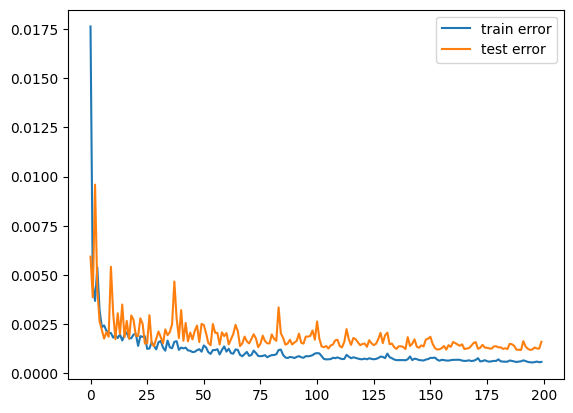

In [14]:
# Initialize the trainer
training = Training(source_model,
                    X_train,                                                              # We train this model on the source data only
                    y_train,
                    X_cal,
                    y_cal,
                    epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list_source, best_epoch_source = training.fit(verbose=True)

In [15]:
# Load the state dictionary of the best performing model
source_model.load_state_dict(state_dict_list_source[best_epoch_source])

<All keys matched successfully>

In [16]:
# Forecast with the model
forecasts = source_model(X_cal.to(device)).cpu().detach().flatten().numpy()

# Evaluate the model performance
mse(y_cal.detach().flatten().numpy(), forecasts)

0.0015773259

# Calibration

In [17]:
predictions = source_model(X_cal.to(device)).cpu().detach().numpy()
#predictions = np.clip(predictions, 0, None)

In [18]:
cal_dates = training_data[24+X_train.shape[0]*24:24+X_train.shape[0]*24+X_cal.shape[0]*24].index

In [19]:
calibration_df = pd.DataFrame({
    "predictions": predictions.flatten(),
    "y_cal": y_cal.detach().flatten().numpy()
}, index=cal_dates)

In [20]:
calibration_df['error'] = calibration_df['predictions']-calibration_df['y_cal']

In [21]:
df = calibration_df

errors = (df["error"]).to_numpy()
months = df.index.month - 1   # 0–11
hours = df.index.hour         # 0–23

# dict keyed by (month, hour), values = list of errors
error_dict = defaultdict(list)

for e, m, h in zip(errors, months, hours):
    error_dict[(m, h)].append(e)

In [44]:
calibration_df

,predictions,y_cal,error
2014-08-10 00:00:00,-0.000050,0.0,-0.000050
2014-08-10 01:00:00,0.008411,0.0,0.008411
2014-08-10 02:00:00,-0.001157,0.0,-0.001157
2014-08-10 03:00:00,-0.000586,0.0,-0.000586
2014-08-10 04:00:00,-0.001015,0.0,-0.001015
...,...,...,...
2017-10-20 19:00:00,-0.000665,0.0,-0.000665
2017-10-20 20:00:00,0.000209,0.0,0.000209
2017-10-20 21:00:00,-0.000233,0.0,-0.000233
2017-10-20 22:00:00,-0.001995,0.0,-0.001995


In [22]:
percentiles = {}

for (m, h), values in error_dict.items():
    if len(values) > 0:
        perc = np.percentile(values, [10, 25, 75, 90])
        percentiles[(m, h)] = {
            "P10": perc[0],
            "P25": perc[1],
            "P75": perc[2],
            "P90": perc[3],
        }

In [23]:
rows = []
for m in range(12):        # months 0–11
    for h in range(24):    # hours 0–23
        vals = error_dict.get((m, h), [])
        if len(vals) > 0:
            perc = np.percentile(vals, [10, 25, 75, 90])
            rows.append([m+1, h, *perc])
        else:
            rows.append([m+1, h, *[np.nan]*4])

In [24]:
df_percentiles = pd.DataFrame(
    rows,
    columns=["month", "hour", "P10", "P25", "P75", "P90"]
)

# Make index chronological: month-hour pairs in order
df_percentiles.index = [
    f"{row.month:02d}-{row.hour:02d}" for row in df_percentiles.itertuples()
]

# Drop redundant columns if you just want index + percentiles
df_percentiles = df_percentiles.drop(columns=["month", "hour"])

In [49]:
df_percentiles

,P10,P25,P75,P90
01-00,-0.003312,-0.002693,-0.000016,0.000746
01-01,-0.002001,0.001069,0.011093,0.012381
01-02,-0.002937,-0.002302,-0.000471,0.000137
01-03,-0.000643,-0.000340,0.000416,0.000662
01-04,-0.000921,-0.000436,0.000687,0.001032
...,...,...,...,...
12-19,-0.007835,-0.003679,0.005255,0.009622
12-20,-0.000995,-0.000487,0.000074,0.000415
12-21,-0.005652,-0.004824,-0.001279,0.000143
12-22,-0.006868,-0.005545,-0.001525,0.000258


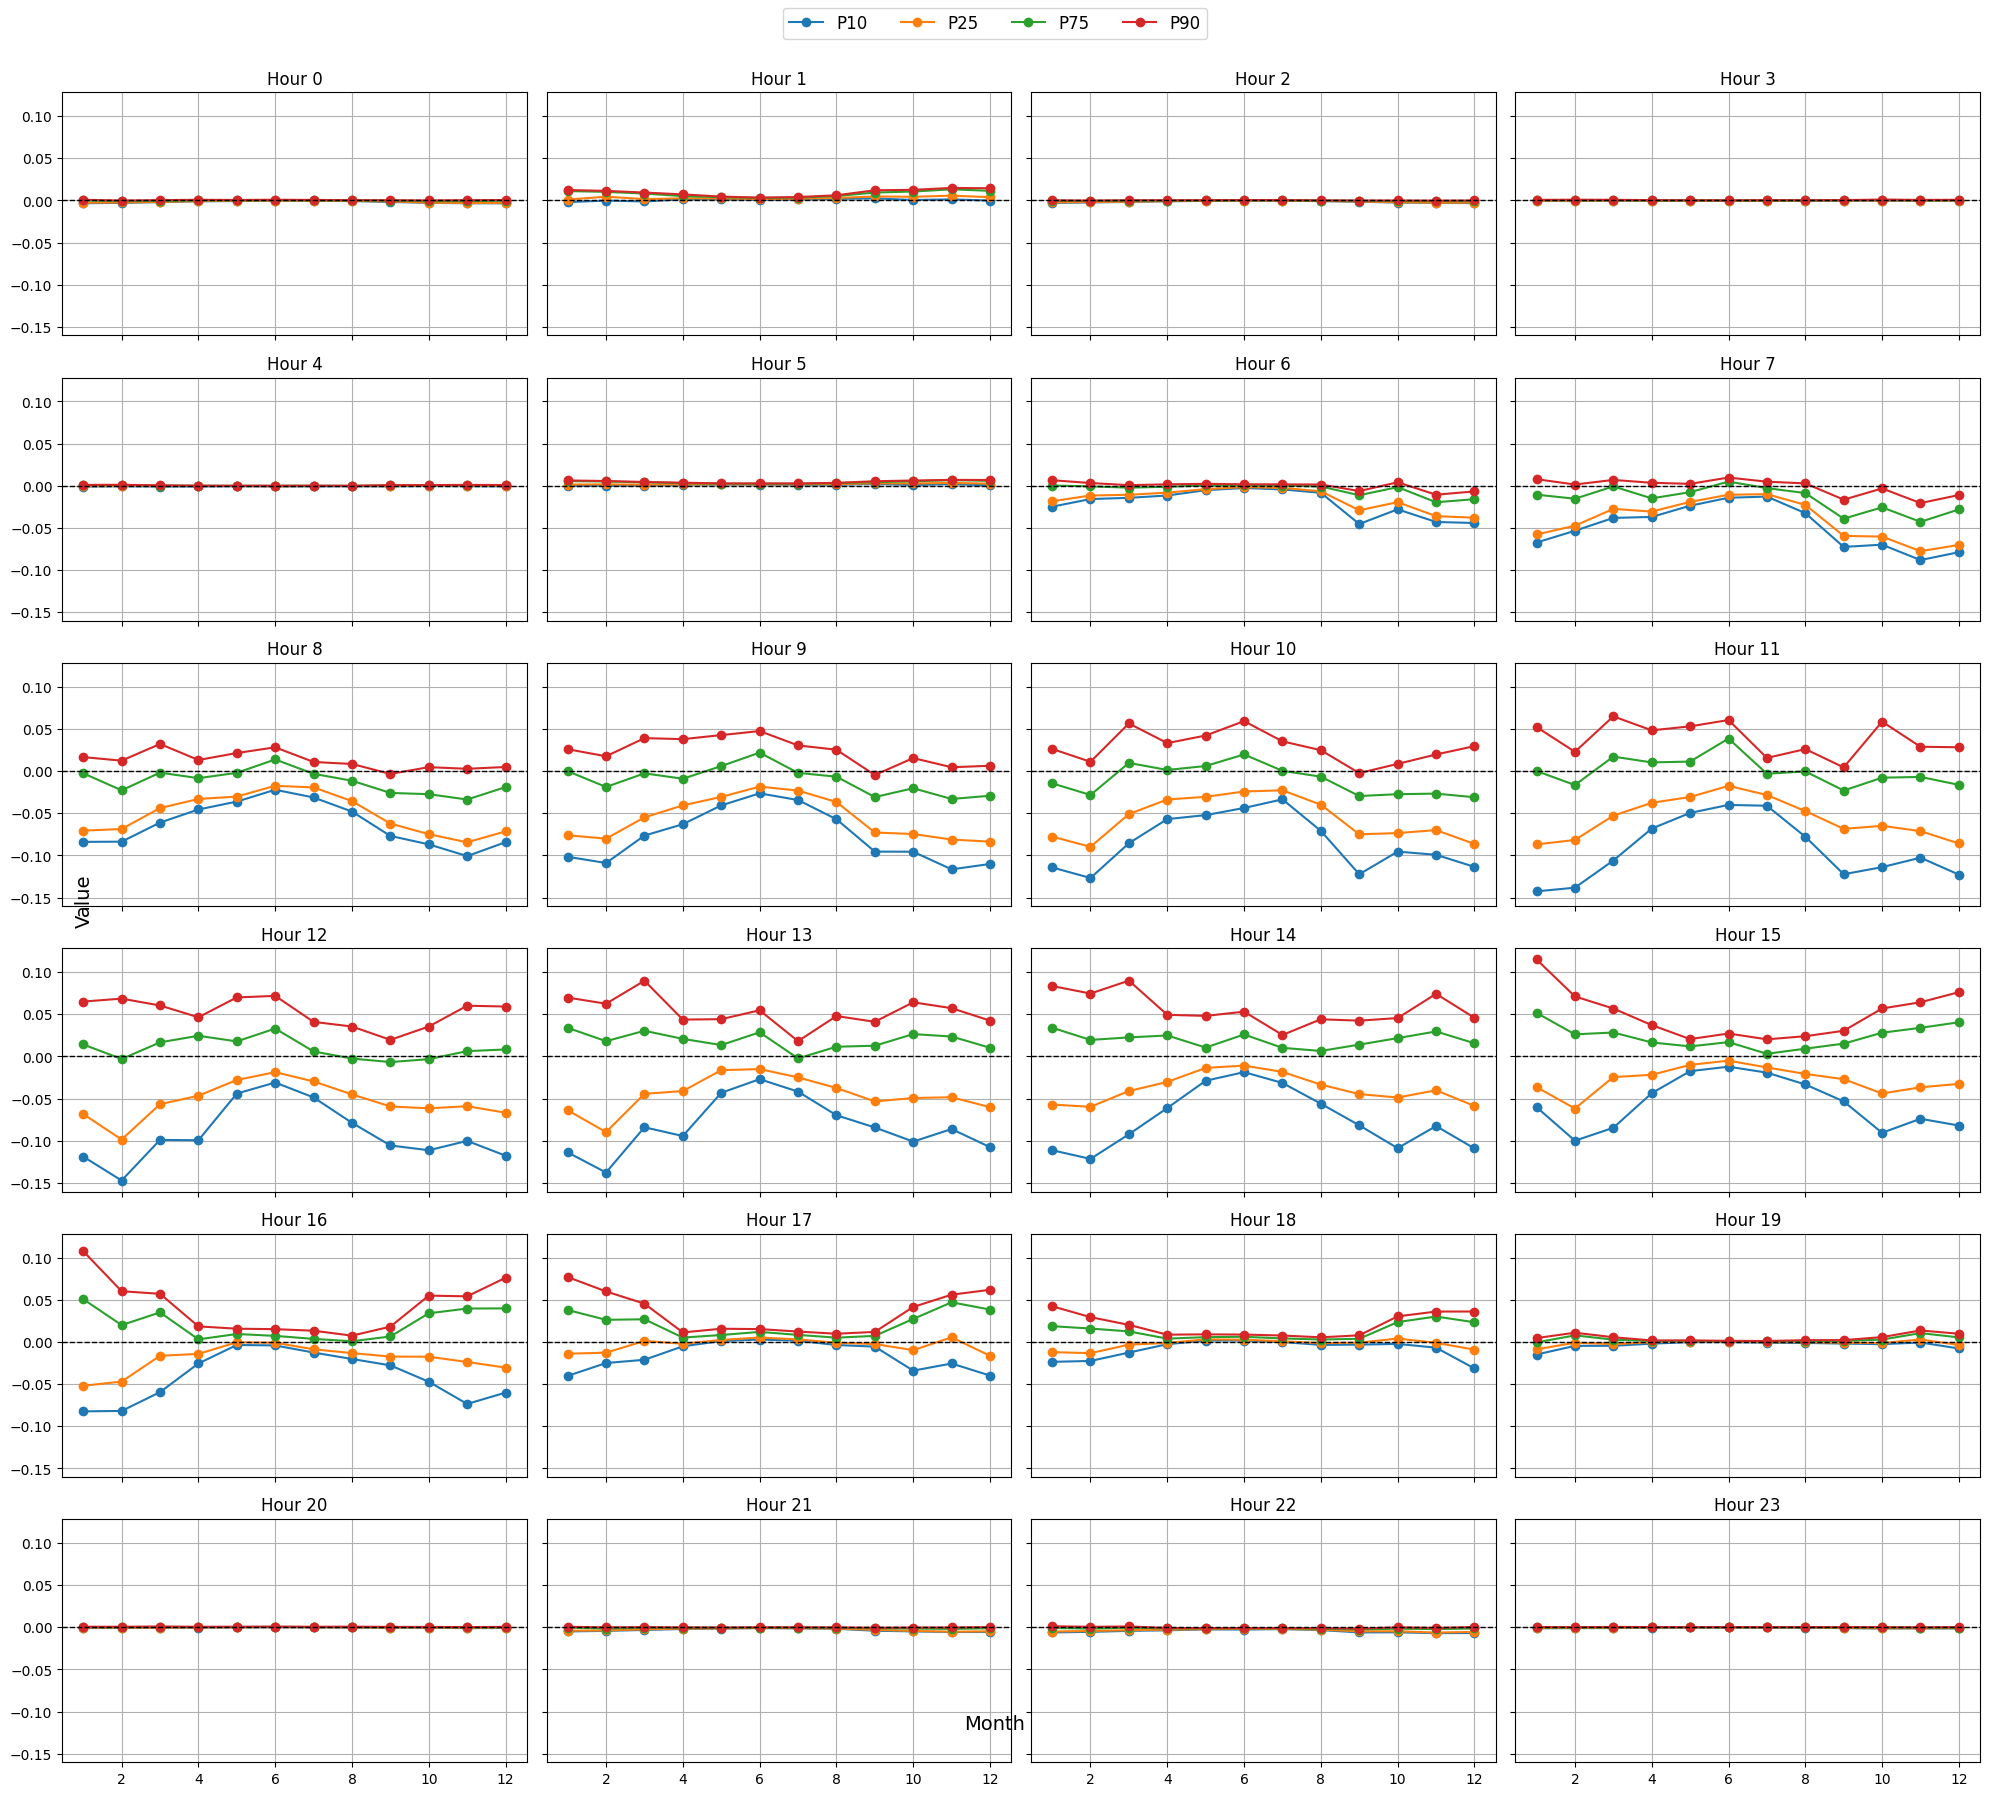

In [57]:
df = df_percentiles

# Reset index to work with it as a column
df = df.reset_index().rename(columns={"index": "month_hour"})

# Split into month and hour
df["month"] = df["month_hour"].str.split("-").str[0].astype(int)
df["hour"] = df["month_hour"].str.split("-").str[1].astype(int)

# Create 24 subplots (matrix 6x4)
fig, axes = plt.subplots(6, 4, figsize=(20, 18), sharex=True, sharey=True)
axes = axes.flatten()

# Loop over 24 hours
for hour in range(24):
    ax = axes[hour]
    df_hour = df[df["hour"] == hour]

    for col in ["P10", "P25", "P75", "P90"]:
        ax.plot(df_hour["month"], df_hour[col], marker="o", label=col)

    # Add horizontal line at y=0
    ax.axhline(0, color="black", linestyle="--", linewidth=1)

    ax.set_title(f"Hour {hour}")
    ax.grid(True)

# Add shared labels and legend
fig.text(0.5, 0.04, 'Month', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=14)

# Add a single legend outside the plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

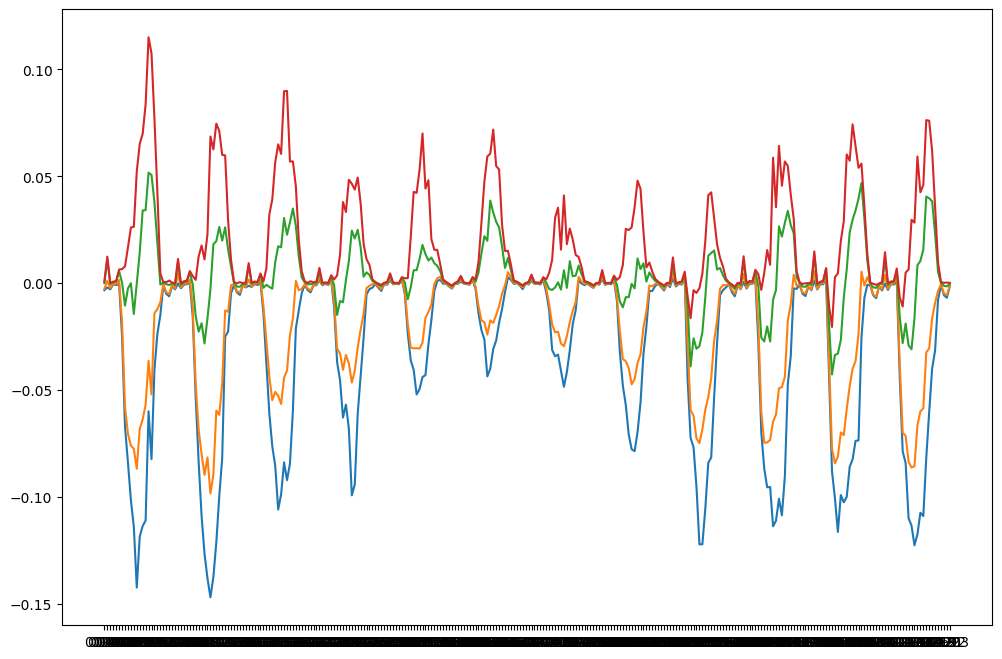

In [25]:
plt.figure(figsize=(12, 8))

plt.plot(df_percentiles)

plt.show()

# Test data

In [35]:
# Forecast with the model
test_forecasts = source_model(X_test.to(device)).cpu().detach().flatten().numpy()
#test_forecasts = np.clip(test_forecasts, 0, None)

In [37]:
test_dates = training_data[24+X_train.shape[0]*24+X_cal.shape[0]*24:].index
test_df = pd.DataFrame({'values':test_forecasts.flatten()}, index=test_dates)
test_df['actuals'] = y_test.detach().flatten().numpy()

In [38]:
# Make sure df_new has datetime index
months = test_df.index.month
hours = test_df.index.hour

# Build keys like "MM-HH"
keys = [f"{m:02d}-{h:02d}" for m, h in zip(months, hours)]

# Reindex percentiles df to match these keys
percs = df_percentiles.loc[keys].reset_index(drop=True)

values = test_df["values"].to_numpy()

# Compute raw sums
raw_P10 = values + percs["P10"].to_numpy()
raw_P25 = values + percs["P25"].to_numpy()
raw_P75 = values + percs["P75"].to_numpy()
raw_P90 = values + percs["P90"].to_numpy()

raw = False

if raw is True:
    test_df["P10"] = raw_P10
    test_df["P25"] = raw_P25
    test_df["P75"] = raw_P75
    test_df["P90"] = raw_P90
else:
    # Apply min/max rules
    test_df["P10"] = np.minimum(values, raw_P10)
    test_df["P25"] = np.minimum(values, raw_P25)
    test_df["P75"] = np.maximum(values, raw_P75)
    test_df["P90"] = np.maximum(values, raw_P90)

# Optionally clip at zero if needed
test_df[["P10","P25"]] = test_df[["P10","P25"]].clip(lower=0)

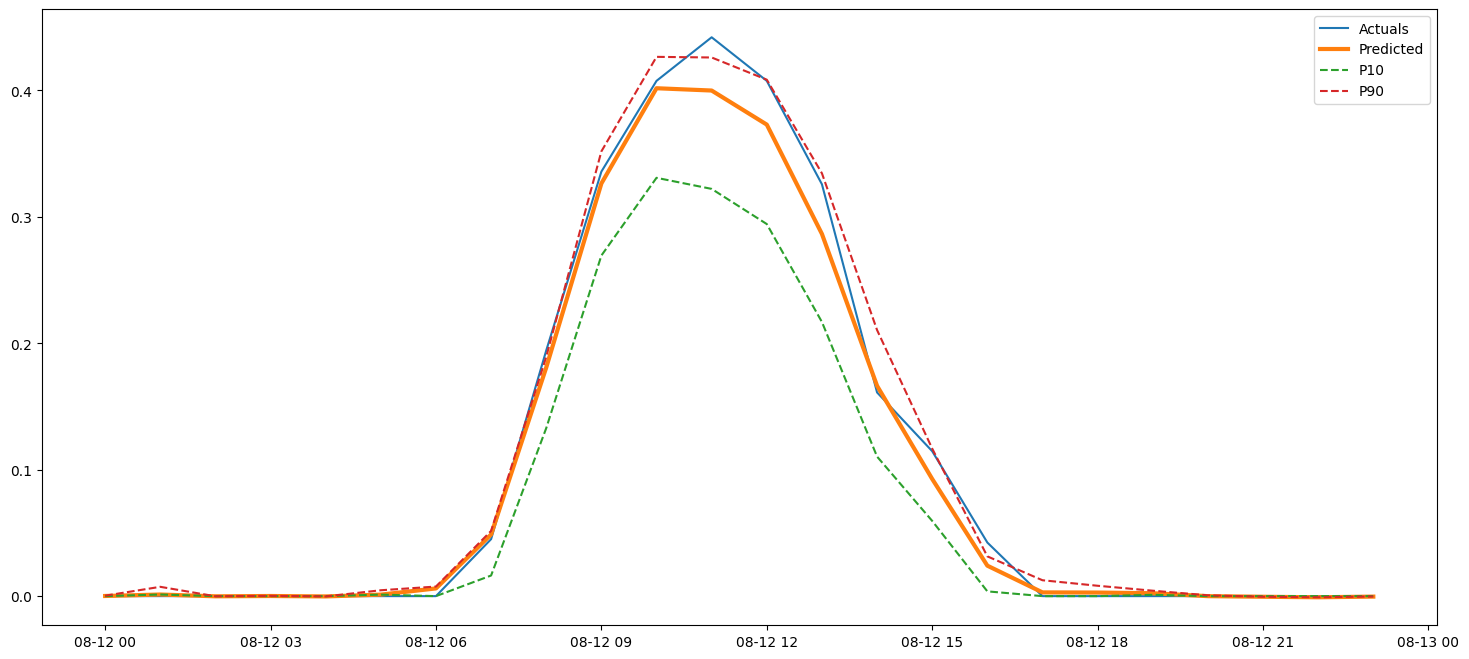

In [39]:
plt.figure(figsize=(18, 8))

plt.plot(test_df['actuals'][48:72], label="Actuals")
plt.plot(test_df['values'][48:72], linewidth=3, label="Predicted")
plt.plot(test_df['P10'][48:72], linestyle='--', label="P10")
plt.plot(test_df['P90'][48:72], linestyle='--', label="P90")

plt.legend()
plt.show()

In [40]:
# Compute pinball loss for each quantile
q10_loss = pinball_loss(test_df["actuals"].to_numpy(), test_df["P10"].to_numpy(), 0.1).mean()
q25_loss = pinball_loss(test_df["actuals"].to_numpy(), test_df["P25"].to_numpy(), 0.25).mean()
q75_loss = pinball_loss(test_df["actuals"].to_numpy(), test_df["P75"].to_numpy(), 0.75).mean()
q90_loss = pinball_loss(test_df["actuals"].to_numpy(), test_df["P90"].to_numpy(), 0.9).mean()

print("Pinball losses:")
print(f"P10: {q10_loss:.4f}, P25: {q25_loss:.4f}, P75: {q75_loss:.4f}, P90: {q90_loss:.4f}")

Pinball losses:
P10: 0.0055, P25: 0.0095, P75: 0.0115, P90: 0.0087


In [41]:
iqr_coverage = ((test_df["actuals"] >= test_df["P25"]) &
                (test_df["actuals"] <= test_df["P75"])).mean()
print(f"IQR coverage: {iqr_coverage:.2f} (target 0.5)")

IQR coverage: 0.24 (target 0.5)


In [42]:
coverage = ((test_df["actuals"] < test_df["P10"]).mean())
print(f"P10 coverage: {coverage:.2f} (target 0.1)")

P10 coverage: 0.18 (target 0.1)


In [43]:
coverage = ((test_df["actuals"] <= test_df["P90"]).mean())
print(f"P90 coverage: {coverage:.2f} (target 0.9)")

P90 coverage: 0.61 (target 0.9)
